# Modelling
<u>Tests using the following models :</u>
* Linear regression
* Random forest regressor
* Ridge and Lasso Regularization (add on to linear modelling?)

<u> Tests using the following variables:</u>
* Weather variables (rain, temperature, windspeed)
* Time variables (Day of week, month, year, time of day, public holiday)
* Sensor environment variables:
    * Sensor_id
    * Betweenness of the street 
    * Sub categories of buildings in proximity to the sensor:
        * Average number of floors of buildings in vicinity
        * Building type - Community use/Education/Entertainment/Events/Hospital or clinic/Office/Parking/Public display area/Residential/Retail/Storage/Transport/Unoccupied/Working
    * Sub categories of landmarks in proximity to the sensor:   
        * Landmark type - Community use/Health services/Leisure or recreation/Mixed use/Office/Place of Assembly/Place of Worship/Retail/ Transport
    * Sub categories of furniture in proximity to the sensor:    
        * Barbeque/Bicycle Rails/Bollard/Drinking fountaion/Crate or planter box/Hoop/Horse trough/Information pillar/Litter bin/Picnic setting/Seat/Tree guard
    * Lights

<u> Thoughts </u>  
Why are so many of the bulding/furniture categories correlated? Are most of the buldings all close together? plot to check.

Landmarks - the maximum number of features is 5 across all the sensors, but many have only 1 or 0. Definitely doesn't seem to make sense to include the subtypes. However, landmakes_transport does seem quite relevant


Normalise variables: should this be with MinMax or StandardScaler??

In [1]:
import copy
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, mean_squared_error,r2_score, accuracy_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import time as thetime
from xgboost import XGBClassifier, XGBRegressor
import datashader as ds
from datashader.mpl_ext import dsshow
from scipy import stats
import math

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

from Functions import *

# Code from: https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib/53865762#53865762
def using_datashader(ax, x, y):
    df = pd.DataFrame(dict(x=x, y=y))
    dsartist = dsshow(df,ds.Point("x", "y"),ds.count(), vmin=0.1, vmax=100,norm="linear",aspect="auto",ax=ax)
    plt.colorbar(dsartist)

### Read in formatted data

In [2]:
data = pd.read_csv("formatted_data_for_modelling.csv", index_col = False)

### Keep only sensors with relatively complete data

In [3]:
### Filter to include just sensors which we know have quite complete data 
data = data[data['sensor_id'].isin([2,6,9,10,14,18])]
data.reset_index(inplace=True, drop = True)

### Get rid of columns 

In [4]:
data = data.drop(['Pressure', 'Humidity'],axis=1) # seem obviously irrelevant
# data = data[data.columns.drop(list(data.filter(regex='h_')))] # (as these are replaced by the categorical ones)
data = data.drop(['sensor_id'],axis=1) # don't want this included
# Get rid of columns in which none of the sensors have a value
for column in data.columns:
    if np.nanmax(data[column]) ==0:
        print(column)
        del data[column]

landmarks_Place of Worship
landmarks_Mixed Use
furniture_Picnic Setting
landmarks_Leisure/Recreation
landmarks_Office
furniture_Barbeque
landmarks_Place Of Assembly
furniture_Hoop
furniture_Horse Trough
landmarks_Health Services


In [5]:
df_subtypes = data.drop(['buildings', 'landmarks', 'furniture'],axis=1)

In [6]:
# df_subtypes[['buildings_Community Use', 'landmarks_Community Use']]
# plt.scatter(df_subtypes['buildings_Community Use'], df_subtypes['landmarks_Community Use'])
# # df_subtypes[.sum(axis=0) 
# # df_subtypes.loc['Total']= df_subtypes.sum()

In [7]:
# for column in df_subtypes.columns:
#     print(column)

In [8]:
cor = df_subtypes.corr()
cor.loc[cor['furniture_Bollard'] >0.6].index
# Furniture_bicyclerails and avg_n_floors = 0.83
# buldings_Working and buildoimgs_community_use = 1
# buildings_education = 'buildings_Education', 'buildings_Retail', 'buildings_Storage','buildings_Unoccupied', 'furniture_Bollard','furniture_Drinking Fountain', 'furniture_Floral Crate/Planter Box','furniture_Information Pillar', 'furniture_Seat', 'landmarks_Community Use', 'landmarks_Retail'

Index(['furniture_Bollard', 'furniture_Drinking Fountain',
       'furniture_Floral Crate/Planter Box', 'furniture_Information Pillar',
       'furniture_Litter Bin', 'furniture_Seat', 'landmarks_Community Use',
       'landmarks_Retail', 'buildings_Entertainment', 'buildings_Retail',
       'buildings_Storage', 'buildings_Unoccupied', 'buildings_Education'],
      dtype='object')

In [9]:
# for column in cor.columns:
#     print(column, len(cor.loc[cor[column] >0.6]))

## Prepare data for modelling - split into predictor/predictand variables

In [10]:
# The predictor variables
Xfull = df_subtypes.drop(['hourly_counts'], axis =1)

# The variable to be predicted
Yfull = df_subtypes['hourly_counts'].values

# Split data into training and test sets
# stratify=y. This tells train_test_split to make sure that the training and test datasets contain examples of 
# each class in the same proportions as in the original dataset
X_train, X_test, Y_train, Y_test = train_test_split(Xfull, Yfull, test_size=0.8, random_state=123)
#                                                   stratify = Yfull)

#### Standardize both training and testing data
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# 
feature_list = list(Xfull.columns)

## Modelling - Linear regression

In [11]:
#### Fit model
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

### Print results
print('Training score: ', lr_model.score(X_train, Y_train))
print('Test score: ', lr_model.score(X_test, Y_test))
print('CV score: ', (cross_val_score(lr_model, X_train, Y_train)).mean())

Training score:  0.4771189861724787
Test score:  0.47927435186667766
CV score:  0.47676539990826905


In [12]:
# Make predictions on the testing data
lr_predictions = lr_model.predict(X_test)
lr_residuals = pd.DataFrame({'Predictions':lr_predictions,'RealValues': Y_test})
lr_residuals['residuals'] = lr_residuals.RealValues - lr_residuals.Predictions

# Not sure what this does
(mean_squared_error(Y_test, lr_predictions))**0.5

# Collect the model coefficients in a dataframe
lr_df_coef = pd.DataFrame(lr_model.coef_, index=X_train.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients to gauge influence (show importance of predictor variables)
lr_df_coef['coef_abs'] = lr_df_coef.coefficients.abs()

In [13]:
lr_feature_importance= lr_df_coef.sort_values(by = 'coefficients', ascending = False)
lr_feature_importance.reset_index(inplace = True)

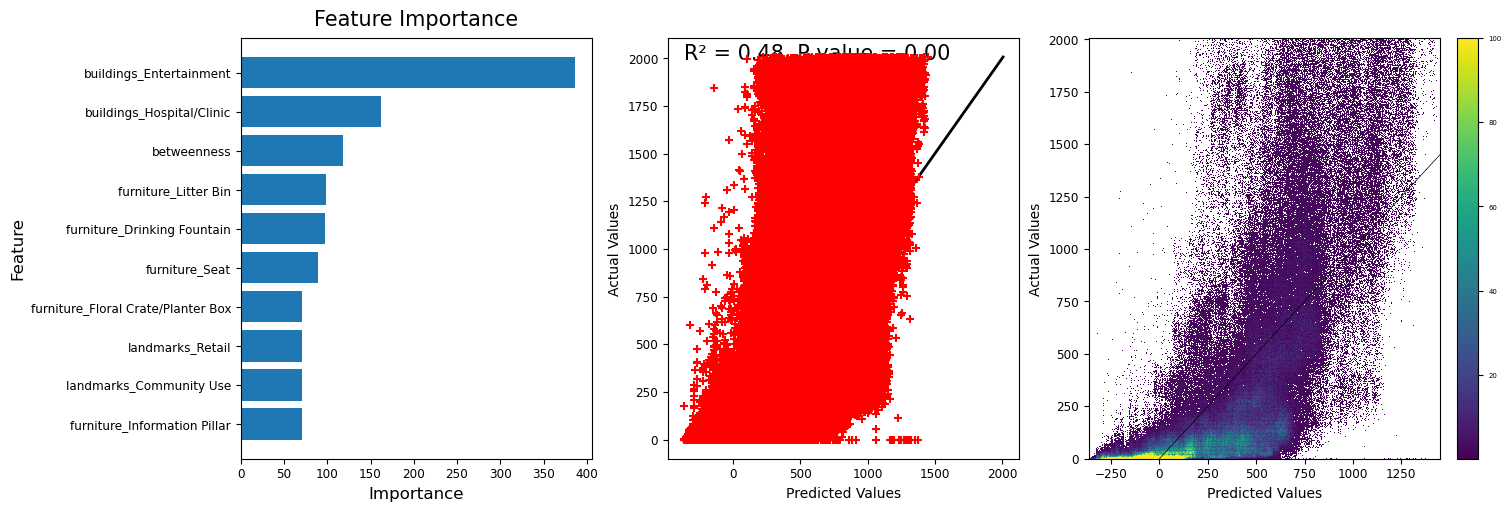

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize = (15,5))

axs[0].barh(lr_feature_importance['index'][:10], lr_feature_importance['coefficients'][:10])
axs[0].invert_yaxis()
plt.rcParams.update({'font.size': 5})
axs[0].set_title("Feature Importance", fontsize=15, y=1.01)
axs[0].set_xlabel('Importance', fontsize = 12)
axs[0].set_ylabel('Feature', fontsize = 12)
axs[0].xaxis.set_tick_params(labelsize='xx-large')
axs[0].yaxis.set_tick_params(labelsize='xx-large')

axs[1].scatter(lr_residuals.Predictions, Y_test, s=30, c='r', marker='+', zorder=10)
m, b, r_value, p_value, std_err = stats.linregress(lr_residuals.Predictions, Y_test)
axs[1].annotate('R\N{SUPERSCRIPT TWO} = ' + str("{:.2f}".format(r_value**2))
                    + ', P value = ' + str("{:.2f}".format(p_value**2)) , 
                     xy=(lr_residuals.Predictions.min() + (lr_residuals.Predictions.min()/150), Y_test.max() - (Y_test.max()/150)),
                   color = 'black', size = 15)
axs[1].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], c='k', lw=2)
axs[1].set_xlabel("Predicted Values", size=10)
axs[1].set_ylabel("Actual Values", size=10)
axs[1].xaxis.set_tick_params(labelsize='xx-large')
axs[1].yaxis.set_tick_params(labelsize='xx-large')

using_datashader(axs[2], lr_predictions, Y_test)
axs[2].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], c='k', lw=0.5)
axs[2].set_xlabel("Predicted Values", size=10)
axs[2].set_ylabel("Actual Values", size=10)
axs[2].xaxis.set_tick_params(labelsize='xx-large')
axs[2].yaxis.set_tick_params(labelsize='xx-large')

plt.show()

## Modelling - Random forest regressor

In [15]:
# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(Xfull, Yfull, test_size=0.6666, random_state=123)
# train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

### Fit model

In [16]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, Y_train);

### Use fitted model to make predictions on the unseen data

In [22]:
# Use the forest's predict method on the test data
rf_predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(rf_predictions - Y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
#
mae = mean_absolute_error(Y_test,rf_predictions)
print("mean_absolute_error: ", mae)

Mean Absolute Error: 98.63 degrees.
mean_absolute_error:  98.62890779472349


In [17]:
mape = mean_absolute_percentage_error(Y_test, rf_predictions)
print("mean_absolute_error: ", mape)

NameError: name 'rf_predictions' is not defined

### Evaluate model performance by comparing to actual values

In [72]:
# Calculate r2 value
m, b, r_value, p_value, std_err = stats.linregress(rf_predictions, Y_test)
print("R2 = ", r_value**2)

R2 =  0.8522868721035459


In [81]:
MSE = np.square(np.subtract(rf_predictions,Y_test)).mean() 
# MSE = np.square(np.subtract(Y_test,rf_predictions)).mean() 
RMSE = math.sqrt(MSE)
print ("RMSE: ", RMSE)

RMSE:  189.02711079955353


In [87]:
rf_predictions

array([ 54.697,  60.123, 549.419, ..., 159.912, 167.056, 520.035])

In [94]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / Y_test)
print(mape)

[ 30.76329114  38.01752577   6.89085603 ...  31.07540984 149.33731343
  57.58636364]


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/footfall_ml/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [33]:
# # evaluate predictions
# rf_accuracy = accuracy_score(Y_test, rf_predictions)
# print("Accuracy: %.2f%%" % (rf_accuracy * 100.0))

### Plot one decision tree from the random forest

In [19]:
# # Pull out one tree from the forest
# tree = rf.estimators_[5]
# # Export the image to a dot file
# export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# # Use dot file to create a graph
# (graph, ) = pydot.graph_from_dot_file('tree.dot')
# # Write graph to a png file
# graph.write_png('tree.png')

In [20]:
# # Limit depth of tree to 3 levels
# rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
# rf_small.fit(X_train, Y_train)
# # Extract the small tree
# tree_small = rf_small.estimators_[5]
# # Save the tree as a png image
# export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# (graph, ) = pydot.graph_from_dot_file('small_tree.dot')
# graph.write_png('tree.png')

### Evaluate the suggested feature importances

In [55]:
# Get numerical feature importances
rf_importances = list(rf.feature_importances_)
rf_feature_importances = pd.DataFrame({'feature': feature_list,'importance':rf_importances})      
rf_feature_importances= rf_feature_importances.sort_values(by = 'importance', ascending = False)

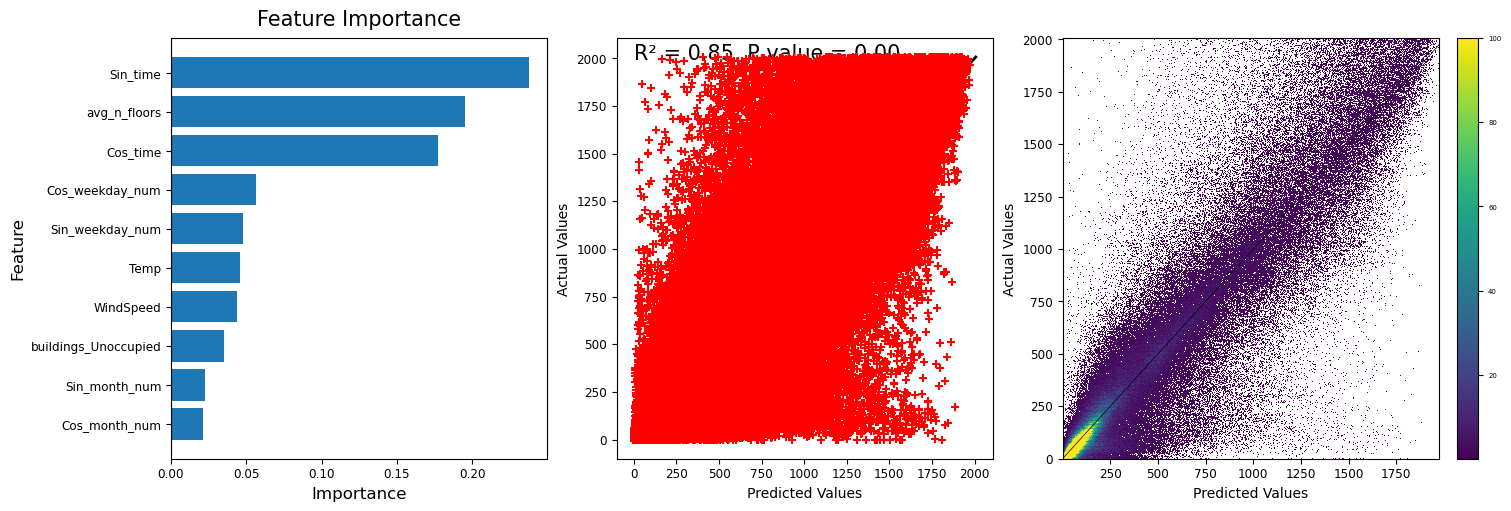

In [62]:
fig, axs = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize = (15,5))

axs[0].barh(rf_feature_importances['feature'][:10], rf_feature_importances['importance'][:10])
axs[0].invert_yaxis()
plt.rcParams.update({'font.size': 5})
axs[0].set_title("Feature Importance", fontsize=15, y=1.01)
axs[0].set_xlabel('Importance', fontsize = 12)
axs[0].set_ylabel('Feature', fontsize = 12)
axs[0].xaxis.set_tick_params(labelsize='xx-large')
axs[0].yaxis.set_tick_params(labelsize='xx-large')

axs[1].scatter(rf_predictions, Y_test, s=30, c='r', marker='+', zorder=10)
axs[1].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], c='k', lw=2)
axs[1].annotate('R\N{SUPERSCRIPT TWO} = ' + str("{:.2f}".format(r_value**2))
                    + ', P value = ' + str("{:.2f}".format(p_value**2)) , 
                     xy=(rf_predictions.min() + (rf_predictions.min()/150), Y_test.max() - (Y_test.max()/150)),
                   color = 'black', size = 15)
axs[1].set_xlabel("Predicted Values", size=10)
axs[1].set_ylabel("Actual Values", size=10)
axs[1].xaxis.set_tick_params(labelsize='xx-large')
axs[1].yaxis.set_tick_params(labelsize='xx-large')

using_datashader(axs[2], rf_predictions, Y_test)
axs[2].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], c='k', lw=0.5)
axs[2].set_xlabel("Predicted Values", size=10)
axs[2].set_ylabel("Actual Values", size=10)
axs[2].xaxis.set_tick_params(labelsize='xx-large')
axs[2].yaxis.set_tick_params(labelsize='xx-large')

plt.show()

## XGBOOST

In [89]:
# fit model no training data
xgb = XGBRegressor()
xgb.fit(X_train, Y_train);

In [76]:
# make predictions for test data
y_pred = xgb.predict(X_test)
xgb_predictions = [round(value) for value in y_pred]

In [91]:
# evaluate predictions
xgb_accuracy = accuracy_score(Y_test, xgb_predictions)
print("Accuracy: %.2f%%" % (xgb_accuracy * 100.0))

Accuracy: 1.00%


In [78]:
# Get numerical feature importances
xgb_importances = list(xgb.feature_importances_)
xgb_feature_importances = pd.DataFrame({'feature': feature_list,'importance':xgb_importances})      
xgb_feature_importances= xgb_feature_importances.sort_values(by = 'importance', ascending = False)

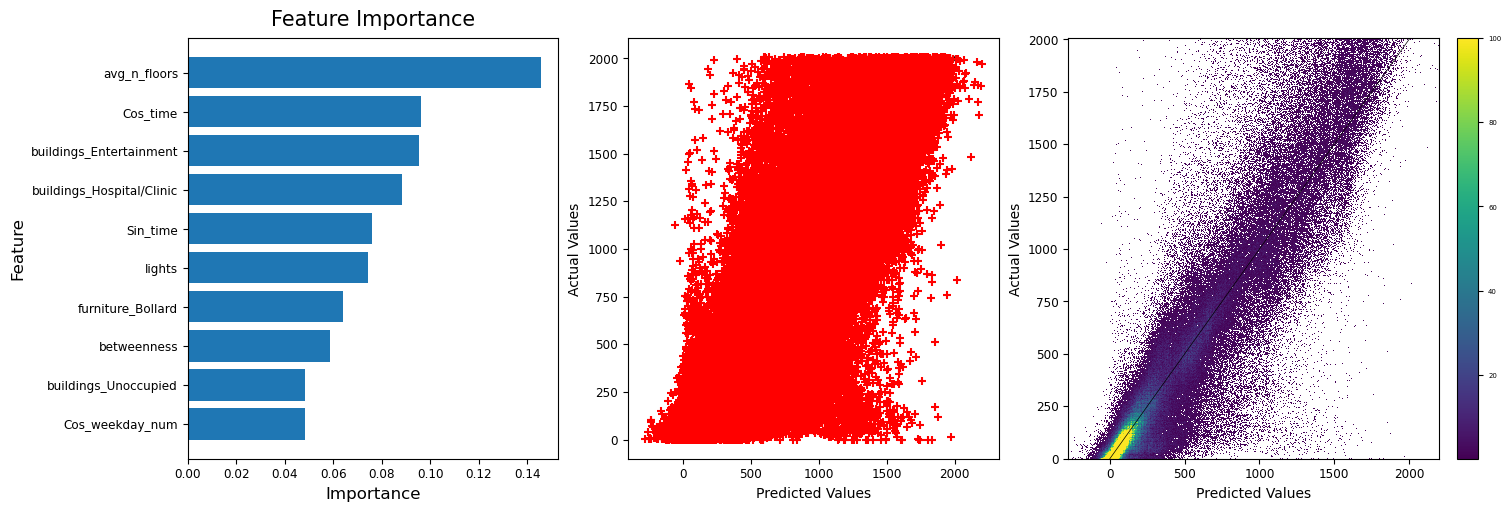

In [81]:
fig, axs = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize = (15,5))

axs[0].barh(xgb_feature_importances['feature'][:10], xgb_feature_importances['importance'][:10])
axs[0].invert_yaxis()
plt.rcParams.update({'font.size': 5})
axs[0].set_title("Feature Importance", fontsize=15, y=1.01)
axs[0].set_xlabel('Importance', fontsize = 12)
axs[0].set_ylabel('Feature', fontsize = 12)
axs[0].xaxis.set_tick_params(labelsize='xx-large')
axs[0].yaxis.set_tick_params(labelsize='xx-large')

axs[1].scatter(xgb_predictions, Y_test, s=30, c='r', marker='+', zorder=10)
axs[1].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], c='k', lw=2)
axs[1].set_xlabel("Predicted Values", size=10)
axs[1].set_ylabel("Actual Values", size=10)
axs[1].xaxis.set_tick_params(labelsize='xx-large')
axs[1].yaxis.set_tick_params(labelsize='xx-large')

using_datashader(axs[2], xgb_predictions, Y_test)
axs[2].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], c='k', lw=0.5)
axs[2].set_xlabel("Predicted Values", size=10)
axs[2].set_ylabel("Actual Values", size=10)
axs[2].xaxis.set_tick_params(labelsize='xx-large')
axs[2].yaxis.set_tick_params(labelsize='xx-large')

plt.show()

### Find the best model  
Use k-fold cross validation to evaluate a range of regression algorithms on the training data. Use a pipeline for evaluation which first scales the (weather) data. Print the results and assess which models perform best.

The following models were trialled:

* Decision Tree
* Random Forest
* Extra Trees
* Dummy Regressor
* Elastic Net CV
* Passive Aggressive
* RANSAC
* SGD
* TheilSen (dropped in code below because it takes too long)
* K Neighbours
* LinearRegression
* XGBoost

In [ ]:
import multiprocessing
from multiprocessing import Pool # To run models in multiple threads simultaneously
import time as thetime
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold

# Define a list of all the models to use
Models = {'LinearRegression': LinearRegression,#'DecisionTree' : DecisionTreeRegressor,
          'RandomForest': RandomForestRegressor,# 'ExtraTrees' : ExtraTreesRegressor,
#           'DummyRegressor' :DummyRegressor, 'ElasticNetCV' : ElasticNetCV, 
#           'PassiveAggressive' : PassiveAggressiveRegressor, #RANSAC': RANSACRegressor, # This one is terrible too
#           'SGD': SGDRegressor, #'TheilSen': TheilSenRegressor, # Drop this - it isn't great and takes too long
#           'KN': KNeighborsRegressor}
            'XGBoost': XGBRegressor}
 
# Now just run each model, but do this in multiple processes simultaneously to save time    
# Now call that function simultaneously for each model
p = Pool(processes=None) # A pool of processes (one for each core)
results = p.map(run_model, [(name, model_type) for name, model_type in Models.items()])

# Sort the results by median mse (that's item 5 in the tuple)
results.sort(key=lambda x: x[5], reverse=True)

# Put the results in a nice dictionary and print them
results_dict = {}
txt = "<table><thead><td>Name</td><td>Median R2</td><td>Median MSE</td><td>runtime (sec)</td></thead>"
for name, model, all_r2, r2, all_mse, mse, runtime in results:
    txt += "<tr><td>{}</td><td>{}</td><td>{}</td><td>{}</td></tr>".format(name, r2, mse, runtime)
    results_dict[name] = (model, all_r2, r2, all_mse, mse, runtime)
txt += "</table>"
display(HTML(txt)) # print as html

min_mse = min([mse for (name, model, all_r2, r2, all_mse, mse, runtime) in results])
               
x =  [ name for (name, model, all_r2, r2, all_mse, mse, runtime) in results]
y1 = [ mse-min_mse   for (name, model, all_r2, r2, all_mse, mse, runtime) in results]
y2 = [ r2 if r2 > 0 else 0 for (name, model, all_r2, r2, all_mse, mse, runtime) in results]

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 7))

ax1.set_title("MSE")
#ax1.invert_yaxis()
ax1.bar(range(len(x)), y1)
ax1.set_xticks(range(len(x)))
ax1.set_xticklabels(x, rotation=90)
ax1.set_ylim([27000000000, 29000000000])

ax2.set_title("R^2")
ax2.bar(range(len(x)), y2)
ax2.set_xticks(range(len(x)))
ax2.set_xticklabels(x, rotation=90)

plt.show()

#del x,y1, y2

## Set up a dictionary containing the hyperparameters we want to tune
hyperparameters_rf = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestregressor__max_depth': [None, 5, 3, 1]}
# hyperparameters_xgb = {'xgbregressor__max_depth': range(1, 11, 2),
#                    'xgbregressor__n_estimators' : range(50, 400, 50),
#                    'xgbregressor__learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}
hyperparameters_lr = {}

# Set up the pipeline containing the scalers
pipeline_rf = make_pipeline(MinMaxScaler(feature_range = (0,1)), 
                         RandomForestRegressor(n_estimators=100))
# pipeline_xgb = make_pipeline(MinMaxScaler(feature_range = (0,1)),
#                          xgb.XGBRegressor(n_estimators=100))
pipeline_lr = make_pipeline(MinMaxScaler(feature_range = (0,1)),
                         LinearRegression())

# Store the scores in a results dictionary (and print them)
final_results = {}
for model_values in [(pipeline_rf,  hyperparameters_rf,  'RandomForest'),
#                      (pipeline_xgb, hyperparameters_xgb, 'XGBoost'),
                     (pipeline_lr,  hyperparameters_lr,  'LinearRegression')]:
    
    clf = GridSearchCV(model_values[0], model_values[1], 
                       #cv = None, # Cross-validation method. None means default (3-fold)
                       cv = 10, # positive intiger means k-fold (e.g. 10-fold)
                       #scoring  = 'neg_mean_squared_error', # MSE to calculate score
                       scoring  = 'r2', # MSE to calculate score
                       n_jobs=multiprocessing.cpu_count()) # Run on multiple cores
    
    #clf = GridSearchCV(model_values[0], model_values[1], cv = 10, scoring  = 'r2')
    clf.fit(X_validate, Y_validate)
    name = model_values[2]
    final_results[name] = clf
    print ("Hyperparameter results for {}".format(name))
    print ("\tBest Score: {}".format(clf.best_score_))
    print ("\tBest params: {}".format(clf.best_params_))